# Experiment Notebook 3 – Vision Transformer & Detectron2 Experiments

This notebook contains the experimental workflow for applying ViT-based architectures
and running additional Detectron2-based object detection experiments.

It includes:
- Environment and library setup (PyTorch, Detectron2)  
- Testing on COCO dataset samples  
- Preparing the custom TCT dataset for object detection  
- Visualizing detection results and analyzing evaluation metrics  

> **Note:** This notebook is focused on experimentation and prototyping and is not part of the model training pipeline.  

In [ ]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import urllib.request
import cv2
import matplotlib.pyplot as plt

### Test on COCO Dataset

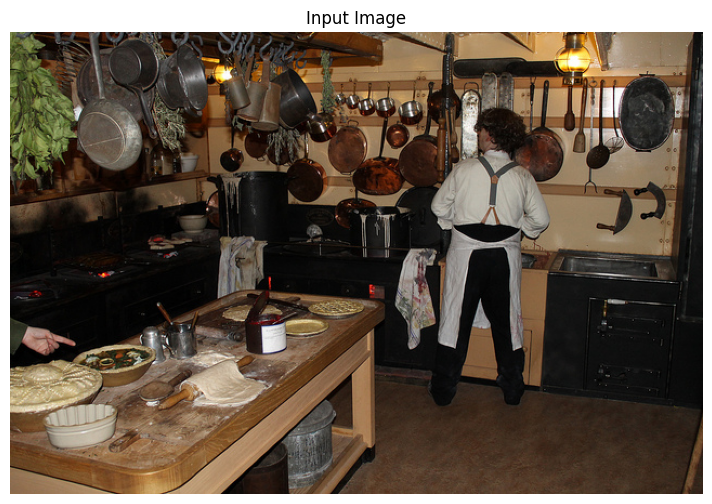

In [ ]:

# Download the image using urllib
image_url = "http://images.cocodataset.org/val2017/000000397133.jpg"
image_path = "input.jpg"
urllib.request.urlretrieve(image_url, image_path)

# Load and convert image
im = cv2.imread(image_path)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(im_rgb)
plt.axis("off")
plt.title("Input Image")
plt.show()

In [10]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[06/06 19:37:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [11]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0, 45, 45, 44, 45, 44, 44, 44, 44, 58, 44, 69, 44, 69])
Boxes(tensor([[3.8692e+02, 6.9130e+01, 5.0156e+02, 3.5367e+02],
        [3.5139e-02, 2.6155e+02, 6.0286e+01, 3.0753e+02],
        [3.0142e+01, 3.4495e+02, 1.0024e+02, 3.8533e+02],
        [1.5445e+02, 1.6866e+02, 1.8341e+02, 1.8571e+02],
        [5.2036e+02, 4.5877e+01, 5.3305e+02, 1.1147e+02],
        [5.8467e+01, 2.8741e+02, 1.3555e+02, 3.2706e+02],
        [5.5347e+02, 4.5192e+01, 5.6601e+02, 1.1036e+02],
        [5.3615e+02, 4.3230e+01, 5.5173e+02, 1.2397e+02],
        [1.3525e+02, 2.4916e+02, 1.5199e+02, 2.7219e+02],
        [5.1138e+02, 4.7614e+01, 5.2241e+02, 9.2246e+01],
        [0.0000e+00, 1.1273e+00, 6.2101e+01, 1.5329e+02],
        [5.5569e+02, 4.4556e+01, 5.6190e+02, 1.1131e+02],
        [4.8888e+02, 1.9939e+02, 6.1850e+02, 3.3775e+02],
        [5.3418e+02, 4.3947e+01, 5.4405e+02, 1.1056e+02],
        [2.3209e+02, 1.8888e+02, 3.8034e+02, 3.3525e+02]]))


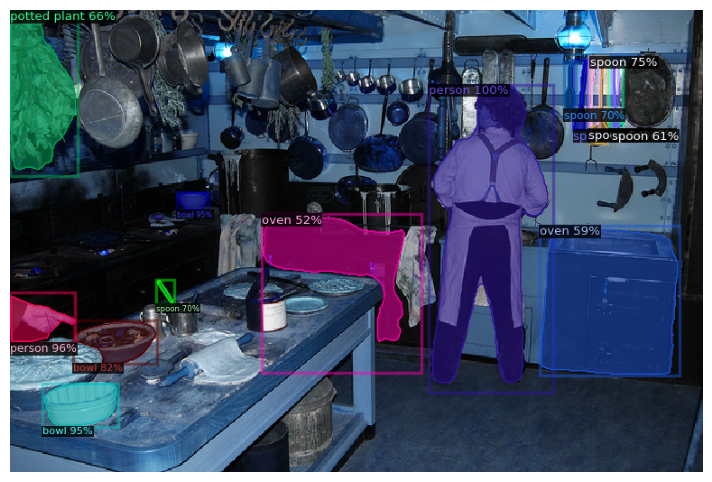

In [12]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
import matplotlib.pyplot as plt

# Visualized image from Detectron2 (BGR to RGB conversion)
vis_image = out.get_image()[:, :, ::-1]

# Display with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(vis_image)
plt.axis("off")
plt.show()

### Prepare Custom Dataset

In [1]:
import os
import pandas as pd
from PIL import Image
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [2]:
def load_tct_dataset(csv_path):
    df = pd.read_csv(csv_path)
    dataset_dicts = []

    for idx, row in df.iterrows():
        img_path = row["image_path"]
        if not os.path.exists(img_path):
            continue

        # Get image size
        image = Image.open(img_path)
        width, height = image.size

        record = {
            "file_name": img_path,
            "image_id": idx,
            "height": height,
            "width": width,
            "annotations": [],
        }

        ann_string = str(row["annotation"])
        ann_list = ann_string.split(";")

        for ann in ann_list:
            if len(ann.strip()) == 0:
                continue

            parts = ann.strip().split()
            if len(parts) != 5:
                continue

            category_id = int(parts[0])  # always 0 in your case
            x1, y1, x2, y2 = map(float, parts[1:])

            obj = {
                "bbox": [x1, y1, x2, y2],  # use native xyxy format
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": category_id,
            }

            record["annotations"].append(obj)

        dataset_dicts.append(record)

    return dataset_dicts

In [3]:
DatasetCatalog.register("tct_train", lambda: load_tct_dataset("../csvfiles/fold1/train.csv"))
MetadataCatalog.get("tct_train").set(thing_classes=["cancer"])

# Register validation set
DatasetCatalog.register("tct_val", lambda: load_tct_dataset("../csvfiles/fold1/val.csv"))
MetadataCatalog.get("tct_val").set(thing_classes=["cancer"])

# Register test set
DatasetCatalog.register("tct_test", lambda: load_tct_dataset("../csvfiles/test.csv"))
MetadataCatalog.get("tct_test").set(thing_classes=["cancer"])

namespace(name='tct_test', thing_classes=['cancer'])

In [4]:
from detectron2.utils.visualizer import Visualizer
import cv2
import random

dataset_dicts = load_tct_dataset("../csvfiles/fold1/train.csv")
metadata = MetadataCatalog.get("tct_train")

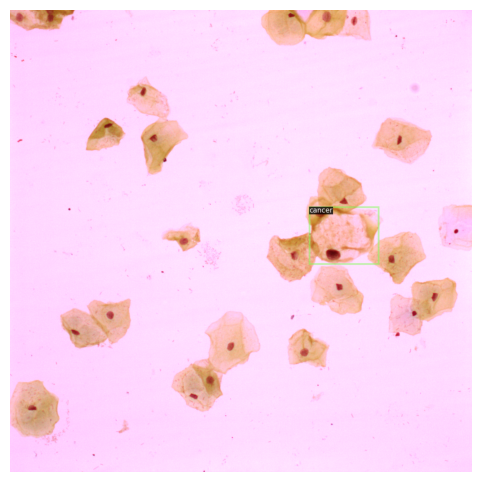

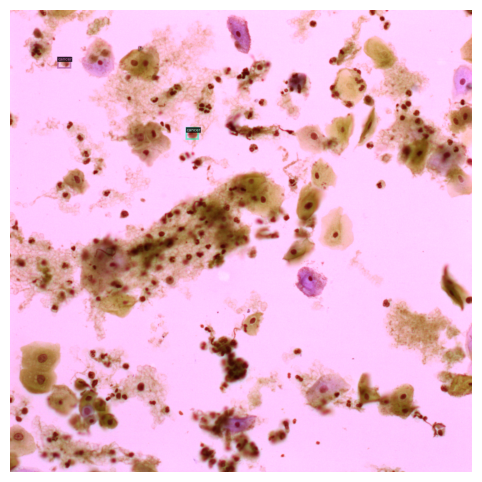

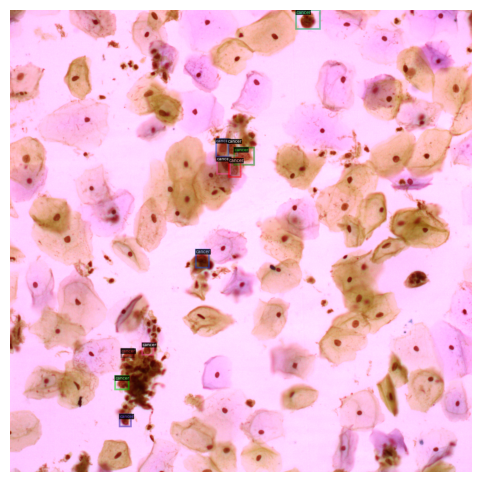

In [10]:
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    vis_image = vis.get_image()[:, :, ::-1]
    plt.figure(figsize=(10, 6))
    plt.imshow(vis_image)
    plt.axis("off")
    plt.show()

### Training

In [ ]:
import os
from functools import partial

import torch
from detectron2.config import LazyConfig
from detectron2.engine import default_setup, DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.logger import setup_logger

setup_logger()

# === Load the LazyConfig ===
cfg = LazyConfig.load("projects/ViTDet/configs/COCO/mask_rcnn_vitdet_h_75ep.py")

# === Modify it for your dataset & task ===
cfg.dataloader.train.dataset.names = "tct_train"
cfg.dataloader.test.dataset.names = "tct_val"

cfg.model.roi_heads.num_classes = 1
cfg.model.mask_on = False  # <--- disable segmentation

cfg.train.output_dir = "./output/vitdet_huge_detection"
os.makedirs(cfg.train.output_dir, exist_ok=True)

# Optional: reduce training length if needed
cfg.train.max_iter = 5000
cfg.train.eval_period = 1000

# === Start training ===
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# End of the Notebook